# Description

UPDATE:

list changes here

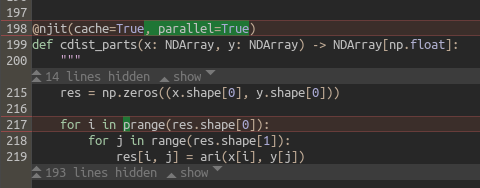

# Remove pycache dir

In [1]:
!echo ${CODE_DIR}

/opt/code


In [2]:
!find ${CODE_DIR} -regex '^.*\(__pycache__\)$' -print

/opt/code/libs/clustermatch/__pycache__


In [3]:
!find ${CODE_DIR} -regex '^.*\(__pycache__\)$' -exec rm -rf {} \;

find: ‘/opt/code/libs/clustermatch/__pycache__’: No such file or directory


In [4]:
!find ${CODE_DIR} -regex '^.*\(__pycache__\)$' -print

# Modules

In [5]:
import numpy as np

from clustermatch.coef import _cm

# Settings

In [6]:
N_REPS = 10

In [7]:
np.random.seed(0)

# Setup

In [8]:
# let numba compile all the code before profiling
_cm.py_func(np.random.rand(10), np.random.rand(10))

(array([0.15625]),
 array([[0, 1]], dtype=uint64),
 [array([[0, 1, 1, 0, 0, 1, 0, 1, 1, 0],
         [1, 2, 1, 1, 0, 2, 0, 2, 2, 0]], dtype=int8),
  array([[1, 0, 0, 1, 0, 0, 0, 1, 1, 1],
         [2, 1, 1, 2, 0, 0, 0, 2, 1, 2]], dtype=int8)])

# Run with `n_samples` small

In [9]:
N_SAMPLES = 100

In [10]:
x = np.random.rand(N_SAMPLES)
y = np.random.rand(N_SAMPLES)

In [11]:
def func():
    for i in range(N_REPS):
        # py_func accesses the original python function, not the numba-optimized one
        # this is needed to be able to profile the function
        _cm.py_func(x, y)

In [12]:
%%timeit -n1 -r1 func()
func()

27.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [13]:
%%prun -s cumulative -l 20 -T 01-n_samples_small.txt
func()

 
*** Profile printout saved to text file '01-n_samples_small.txt'. 


         154 function calls in 0.032 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.032    0.032 {built-in method builtins.exec}
        1    0.000    0.000    0.032    0.032 <string>:1(<module>)
        1    0.000    0.000    0.032    0.032 1556911885.py:1(func)
       10    0.001    0.000    0.032    0.003 coef.py:265(_cm)
       10    0.021    0.002    0.021    0.002 coef.py:198(cdist_parts)
       20    0.010    0.000    0.010    0.000 coef.py:169(_get_parts)
       20    0.000    0.000    0.000    0.000 coef.py:119(_get_range_n_clusters)
       10    0.000    0.000    0.000    0.000 {method 'argmax' of 'numpy.ndarray' objects}
       20    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
       10    0.000    0.000    0.000    0.000 {built-in method numpy.empty}
       10    0.000    0.000    0.000    0.000 coef.py:248(unravel_index_2d)
       10    0.000    0.000    0.

**No improvement** for this case.

# Run with `n_samples` large

In [14]:
N_SAMPLES = 100000

In [15]:
x = np.random.rand(N_SAMPLES)
y = np.random.rand(N_SAMPLES)

In [16]:
def func():
    for i in range(N_REPS):
        # py_func accesses the original python function, not the numba-optimized one
        # this is needed to be able to profile the function
        _cm.py_func(x, y)

In [17]:
%%timeit -n1 -r1 func()
func()

14.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
%%prun -s cumulative -l 20 -T 01-n_samples_large.txt
func()

 
*** Profile printout saved to text file '01-n_samples_large.txt'. 


         154 function calls in 14.819 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   14.819   14.819 {built-in method builtins.exec}
        1    0.000    0.000   14.819   14.819 <string>:1(<module>)
        1    0.005    0.005   14.819   14.819 1556911885.py:1(func)
       10    0.009    0.001   14.815    1.481 coef.py:265(_cm)
       20   11.105    0.555   11.105    0.555 coef.py:169(_get_parts)
       10    3.700    0.370    3.700    0.370 coef.py:198(cdist_parts)
       20    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
       20    0.000    0.000    0.000    0.000 coef.py:119(_get_range_n_clusters)
       10    0.000    0.000    0.000    0.000 {method 'argmax' of 'numpy.ndarray' objects}
       10    0.000    0.000    0.000    0.000 {built-in method numpy.empty}
       10    0.000    0.000    0.000    0.000 coef.py:248(unravel_index_2d)
       10    0.000    0.000    0

**Important improvement** for this case. `cdist_parts` takes now 0.370 percall instead of 0.824 (from reference).